# Move and visualization dataset

In [49]:
import os, random, shutil, csv
import pandas as pd

In [50]:
def get_Diease_Path_List(data_path: str):
    '''
    get the prefix data path list, like "/workspace/data/dataset/train/ASD", len = 4

    Args:
        data_path (str): meta data path

    Returns:
        list: list of the prefix data path list, len=4
    '''

    diease_path_list = []

    for flag in ('train', 'val'):

        data_path_flag = os.path.join(data_path, flag)

        for diease_flag in (os.listdir(data_path_flag)):  # ASD, ASD_not

            data_path_diease_flag = os.path.join(data_path_flag, diease_flag)

            diease_path_list.append(data_path_diease_flag)

    return diease_path_list

In [51]:
def get_final_video_path_Dict(prefix_path_list: list):
    '''
    get the all final video full path, in dict. 
    the keys mean the unique data with the disease.
    the values mean in on data with disease, how many file they are, store in List.

    Args:
        prefix_path_list (list): the prefix path list, like /train/ASD; /train/ASD_not; /val/ASD; /val/ASD_not.

    Returns:
        Dict: the all final video full path, store in dict.
    '''

    final_video_path_Dict = {}

    for data_path_flag_diease in prefix_path_list:

        compare_video_name_list = []

        # all video path
        video_path_list = os.listdir(data_path_flag_diease)

        # start compare video path list
        for compare_video_name in video_path_list:

            compare_video_name_list.append(compare_video_name[:15])

        compare_video_file_name = list(set(compare_video_name_list))

        for name in compare_video_file_name:

            video_same_path_list = []

            for video_path_name in video_path_list:

                now_video_path_name = video_path_name[:15]

                if now_video_path_name in name:

                    # store the full path of unique data with diease in a list.
                    video_same_path_list.append(os.path.join(data_path_flag_diease, video_path_name))

            video_same_path_list.sort()

            final_video_path_Dict[os.path.join(data_path_flag_diease, name[:15])] = video_same_path_list

    return final_video_path_Dict

In [52]:
# Path
SPLIT_PAD_DATA_PATH = "/workspace/data/split_pad_dataset_512/raw/"
SPLIT_DATA_PATH = "/workspace/data/split_dataset_512"

prefix_path_list = get_Diease_Path_List(SPLIT_PAD_DATA_PATH)

final_video_path_Dict = get_final_video_path_Dict(prefix_path_list)


In [53]:
X = []
y = []
groups = []

for key in final_video_path_Dict.keys():

    now_video_path_list = final_video_path_Dict[key]
    now_video_path_list.sort()
    
    flag = key.split('/')

    label = flag[-2]
    group = flag[-1]

    for video_path in now_video_path_list:
        X.append(video_path)
        y.append(label)
        groups.append(group)

In [54]:
from shutil import copyfile

def del_folder(path, *args):
    '''
    delete the folder which path/version

    Args:
        path (str): path
        version (str): version
    '''
    if os.path.exists(os.path.join(path, *args)):
        shutil.rmtree(os.path.join(path, *args))


def make_folder(path, *args):
    '''
    make folder which path/version

    Args:
        path (str): path
        version (str): version
    '''
    if not os.path.exists(os.path.join(path, *args)):
        os.makedirs(os.path.join(path, *args))
        print("success make dir! where: %s " % os.path.join(path, *args))
    else:
        print("The target path already exists! where: %s " % os.path.join(path, *args))

def make_split_pad_folder(split_pad_data_path: str):
    '''
    make the split pad video folder, for /train/ASD; /train/ASD_not;, /val/ASD; /val/ASD_not

    Args:
        split_pad_data_path (str): '/workspace/data/split_pad_dataset'
    '''

    folder_list = []

    for flag in ('train', 'val'):

        data_path_flag = os.path.join(split_pad_data_path, flag)

        for diease_flag in ('ASD', 'ASD_not'):

            final_split_pad_data_path = os.path.join(data_path_flag, diease_flag)

            del_folder(final_split_pad_data_path)
            make_folder(final_split_pad_data_path)
            folder_list.append(final_split_pad_data_path)        

    return folder_list


In [55]:
def copy_file(path_Dict: dict, i:int, ):
    # should delete the existed file！

    # target folder list 
    pref_path = os.path.join('/workspace/data/split_pad_dataset_512', str('fold%d' %i))
    folder_list = make_split_pad_folder(pref_path)

    for key in path_Dict.keys():

        if 'train' in key.split('_'):
            train_val = 'train'
        else:
            train_val = 'val'

        if 'not' in key.split('_'):
            flag = 'ASD_not'
        else:
            flag = 'ASD'

        for path in path_Dict[key]:
            video_name = path.split('/')[-1]

            copyfile(path, os.path.join(pref_path, train_val, flag, video_name))
        
        print('finish' + str(key))

# finish group K fold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

index_Dict = {}
fold_Dict = {}
df_list = []

sgkf = StratifiedGroupKFold(n_splits=5)
for i, (train_idxs, test_idxs) in enumerate(sgkf.split(X, y, groups=groups)):
    index_Dict[i] = train_idxs, test_idxs

    train_asd = []
    train_asd_not = []
    val_asd = []
    val_asd_not = []

    # train 
    for index in train_idxs:

        label_flag = X[index].split('/')[-2]

        if label_flag == 'ASD':
            train_asd.append(X[index]) 
        else:
            train_asd_not.append(X[index])

    # val 
    for index in test_idxs:

        label_flag = X[index].split('/')[-2]

        if label_flag == 'ASD':
            val_asd.append(X[index])
        else:
            val_asd_not.append(X[index])

    print('finish fold%d!' % i)
    print('train_asd %d, train_asd_not %d, val_asd %d, val_asd_not %d' % (len(train_asd), len(train_asd_not), len(val_asd), len(val_asd_not)))
    print('total number %d' % sum([len(train_asd), len(train_asd_not), len(val_asd), len(val_asd_not)]))
    copy_file(
        {
            'train_asd': train_asd,
            'train_asd_not': train_asd_not,
            'val_asd': val_asd,
            'val_asd_not': val_asd_not
        },
        i
    )  
    print('--'*30)  
    data = {
        'train_asd': pd.Series(train_asd), 
        'train_asd_not': pd.Series(train_asd_not), 
        'val_asd': pd.Series(val_asd), 
        'val_asd_not': pd.Series(val_asd_not)
    }

    df_list.append(pd.DataFrame(data))

# make different fold to one excel file.
with pd.ExcelWriter('output.xlsx') as writer:
    for i, df in enumerate(df_list):
        df.to_excel(writer, 'fold%d' %i)



finish fold0!
train_asd 836, train_asd_not 728, val_asd 210, val_asd_not 183
total number 1957
success make dir! where: /workspace/data/split_pad_dataset_512/fold0/train/ASD 
success make dir! where: /workspace/data/split_pad_dataset_512/fold0/train/ASD_not 
success make dir! where: /workspace/data/split_pad_dataset_512/fold0/val/ASD 
success make dir! where: /workspace/data/split_pad_dataset_512/fold0/val/ASD_not 
finishtrain_asd
finishtrain_asd_not
finishval_asd
finishval_asd_not
------------------------------------------------------------
finish fold1!
train_asd 837, train_asd_not 729, val_asd 209, val_asd_not 182
total number 1957
success make dir! where: /workspace/data/split_pad_dataset_512/fold1/train/ASD 
success make dir! where: /workspace/data/split_pad_dataset_512/fold1/train/ASD_not 
success make dir! where: /workspace/data/split_pad_dataset_512/fold1/val/ASD 
success make dir! where: /workspace/data/split_pad_dataset_512/fold1/val/ASD_not 
finishtrain_asd
finishtrain_asd_n

# Visualizing CV behavior

In [56]:
uid_X = X.copy()
uid_y = y.copy()
uid_groups = groups.copy()

random_num = [i for i in range(int(len(set(uid_groups))))]

for index, i in enumerate(set(uid_groups)):
    for num, j in enumerate(uid_groups):
        if i == j:
            uid_groups[num] = index

for index, i in enumerate(set(uid_y)):
    for num, j in enumerate(uid_y):
        if i == j:
            uid_y[num] = index

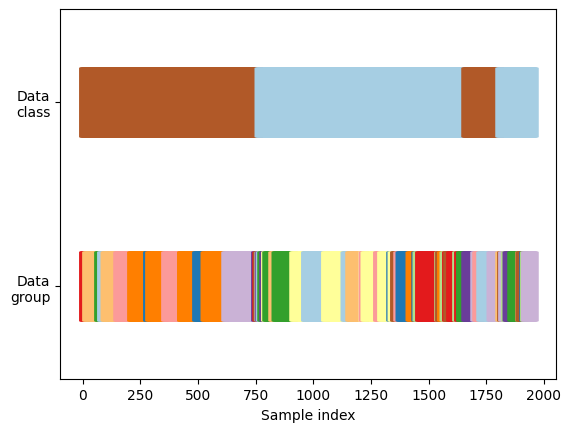

In [57]:
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(uid_y, uid_groups, "no groups")

<Axes: title={'center': 'StratifiedGroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

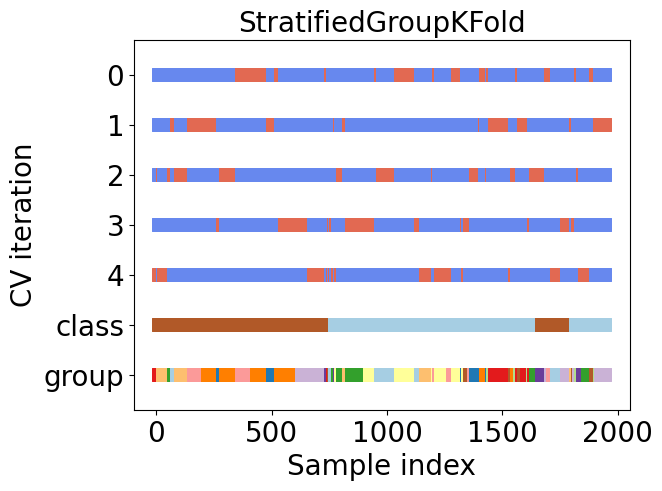

In [78]:
import numpy as np 
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax:plt, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=20)

    return ax

fig, ax = plt.subplots()
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
sgkf = StratifiedGroupKFold(n_splits=5)
plot_cv_indices(sgkf, X, uid_y, uid_groups, ax, 5)

In [59]:
# # csv api
# with open('/workspace/test.cvs', 'w') as csvfile:

#     writer = csv.writer(csvfile)
#     for i in index_Dict[0]:
#         writer.writerow(['------------------', len(i)])
#         writer.writerow(['X', 'y', 'groups'])
#         for j in i:
#             writer.writerow([X[j]])
#             writer.writerow([y[j]])
#             writer.writerow([groups[j]])

In [60]:
# if __name__ == '__main__':
#     fileDir = "/workspace/data/walk_data_finish_train/lat"  # 源视频文件夹路径
#     tarDir = '/workspace/data/dataset/'  # 移动到新的文件夹路径

#     # check if tarDir is exec
#     for flag in ("predict", "train", "val"):
#         del_folder(tarDir, flag)
#         make_folder(tarDir, flag)
#     print("finish check!")
    
    